<a href="https://colab.research.google.com/github/yakovsushenok/Thesis/blob/main/MelSpectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import pandas as pd
import math, random
import torch
import torchaudio
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
from google.colab import drive
from sklearn.model_selection import StratifiedShuffleSplit
drive.mount('/content/gdrive')
import time
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
try:
    from scipy.fftpack import fft, ifft
except ImportError:
    from numpy.fft import fft, ifft
from scipy.signal import lfilter
import scipy.io as sio
from scipy import signal
import gc
import h5py
from torchsummary import summary
!pip install torchmetrics
from torchmetrics.functional import f1_score
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 36.3 MB/s 


In [ ]:
# extracting the training data (audio files) from the zip file (12 minutes)
zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/train_short_audio.zip', 'r')
zip_ref.extractall('/content/tmp') 
zip_ref.close()

In [ ]:
df_500 = pd.read_csv("/content/gdrive/MyDrive/train_metadata_more_than_500.csv")
df_500['primary_label'] = df_500['primary_label'].apply(lambda x: x - 1)
df_500 = df_500[['relative_path', 'primary_label']]

In [ ]:
transform = transforms.MelSpectrogram(sample_rate=32000, n_mels = 128, f_min = 0, f_max = 16000,n_fft = 3200, win_length = 3200, hop_length = 800)
def get_mel_spec_from_file(file):
  mid = 2000000 # truncating or cutting the waveform tensors are less or more length
  waveform, sr = torchaudio.load(file)
  top_db = 80
  if len(waveform[0]) < mid:
    target = torch.zeros(mid) + 0.0005
    source = waveform[0]
    target[:len(source)] = source 
    spec = transform(target)
    return transforms.AmplitudeToDB(top_db=top_db)(spec)
  waveform = waveform[0]
  spec = transform(waveform[:mid])
  return transforms.AmplitudeToDB(top_db=top_db)(spec)

In [ ]:
class MelSpecDS(Dataset):
  def __init__(self, df):
    self.df = df
  
  def __len__(self):
    return len(self.df)    
    
  def __getitem__(self, idx):
   spec = get_mel_spec_from_file(self.df['relative_path'].iloc[idx])
   return (spec, torch.tensor(self.df['primary_label'].iloc[idx]))

def inference(model, val_dl):
  correct_prediction = 0
  total_prediction = 0
  outputsList = []
  labelsList = []
  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)


      inputs -= inputs.min(1, keepdim=True)[0]
      inputs /= inputs.max(1, keepdim=True)[0]
      
      inputs = inputs[None, :, :, :]
      inputs = inputs.permute(1,0,2,3)
      if torch.isnan(inputs).any() == True:
          inputs = torch.nan_to_num(inputs, nan = 0.5)
      # Get predictions
      outputs = model(inputs.float())

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
      outputsList.append(prediction.cpu().numpy())
      labelsList.append(labels.cpu().numpy())
  
  acc = correct_prediction/total_prediction
  print(f'Val Accuracy: {acc:.2f}')
  outputs = np.concatenate(outputsList)
  targets = np.concatenate(labelsList)
  f1 = f1_score(torch.from_numpy(outputs),torch.from_numpy(targets), num_classes = 12, average='micro')
  print(f"F1 score: {f1}")


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

class ResBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=3, stride=2 if downsample else 1, padding=1)
        self.conv3 = nn.Conv2d(out_channels//4, out_channels, kernel_size=1, stride=1)
        self.shortcut = nn.Sequential()

        if self.downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if self.downsample else 1),
                nn.BatchNorm2d(out_channels)
            )

        self.bn1 = nn.BatchNorm2d(out_channels//4)
        self.bn2 = nn.BatchNorm2d(out_channels//4)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = nn.ReLU()(self.bn3(self.conv3(input)))
        input = input + shortcut
        return nn.ReLU()(input)

class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, repeat, useBottleneck=False, outputs=12):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        if useBottleneck:
            filters = [64, 256, 512, 1024, 2048]
        else:
            filters = [64, 64, 128, 256, 512]

        self.layer1 = nn.Sequential()
        self.layer1.add_module('conv2_1', resblock(filters[0], filters[1], downsample=False))
        for i in range(1, repeat[0]):
                self.layer1.add_module('conv2_%d'%(i+1,), resblock(filters[1], filters[1], downsample=False))

        self.layer2 = nn.Sequential()
        self.layer2.add_module('conv3_1', resblock(filters[1], filters[2], downsample=True))
        for i in range(1, repeat[1]):
                self.layer2.add_module('conv3_%d' % (i+1,), resblock(filters[2], filters[2], downsample=False))

        self.layer3 = nn.Sequential()
        self.layer3.add_module('conv4_1', resblock(filters[2], filters[3], downsample=True))
        for i in range(1, repeat[2]):
            self.layer3.add_module('conv2_%d' % (i+1,), resblock(filters[3], filters[3], downsample=False))

        self.layer4 = nn.Sequential()
        self.layer4.add_module('conv5_1', resblock(filters[3], filters[4], downsample=True))
        for i in range(1, repeat[3]):
            self.layer4.add_module('conv3_%d'%(i+1,), resblock(filters[4], filters[4], downsample=False))

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(filters[4], outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)

        return input


device = torch.device("cuda:0" if torch.cuda.is_available() else  "cpu") #

myModel = ResNet(1, ResBlock, [2, 2, 2, 2], useBottleneck=False, outputs=12) # resnet18
#myModel = ResNet(3, ResBottleneckBlock, [3, 4, 6, 3], useBottleneck=True, outputs=12) # resnet50
#myModel = ResNet(3, ResBottleneckBlock, [3, 8, 36, 3], useBottleneck=True, outputs=12)
device = torch.device("cuda:0" if torch.cuda.is_available() else  "cpu") #
myModel = myModel.to(device)




def training(model, train_dl, num_epochs, val_dl):
  # Loss Function, Optimizer 
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr= 10**(-5))
  
  # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.00001,
  #                                               steps_per_epoch=int(len(train_dl)),
  #                                               epochs=num_epochs,
  #                                               anneal_strategy='linear')

  # Epoch iterator
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
    indices = []
    # Batch iterator
    j = 0
    for i, data in enumerate(train_dl):

        inputs, labels = torch.tensor(data[0]).to(device), torch.tensor(data[1]).to(device) # Get the input features and target labels, and put them on the GPU
        if torch.isnan(torch.tensor(data[0])).any() == True:
          j += 1
          continue
        
        d = inputs
        inputs -= inputs.min(0, keepdim=True)[0]
        inputs /= inputs.max(0, keepdim=True)[0]
        inputs = inputs[None, :, :, :]
        inputs = inputs.permute(1,0,2,3)
        if torch.isnan(inputs).any() == True:
          inputs = torch.nan_to_num(inputs, nan = 0.5)
        if torch.isnan(inputs).any() == True:
          print("AAAAAAA")
        #print(inputs)
        optimizer.zero_grad() # Zero the parameter gradients

        # forward + backward + optimize
        outputs = model(inputs.float())
       # print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        running_loss += loss.item() # Keep stats for Loss and Accuracy

        _, prediction = torch.max(outputs,1) # Get the predicted class with the highest score
        #print(prediction, labels)
        correct_prediction += (prediction == labels).sum().item() # Count of predictions that matched the target label
        total_prediction += prediction.shape[0]

    
    # Print stats at the end of the epoch
    print(j)
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch + 1}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')
    print(f"TESTING:")
    inference(model, val_dl)
    print("\n")

  print('Finished Training')



NUM_EPOCHS = 40
# Initializing the dataset
myds = MelSpecDS(df_500)
# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items*(0.80))
num_val = num_items - num_train
print(num_train,num_val)
train_ds, val_ds = random_split(myds, [num_train, num_val])
# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=10, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=10, shuffle=False)

training(myModel, train_dl, NUM_EPOCHS, val_dl) # Training

4800 1200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0
Epoch: 1, Loss: 2.34, Accuracy: 0.19
TESTING:
Val Accuracy: 0.18
F1 score: 0.17999999225139618


0
Epoch: 2, Loss: 2.00, Accuracy: 0.35
TESTING:
Val Accuracy: 0.29
F1 score: 0.28583332896232605


0
Epoch: 3, Loss: 1.74, Accuracy: 0.44
TESTING:
Val Accuracy: 0.35
F1 score: 0.3474999964237213


0
Epoch: 4, Loss: 1.59, Accuracy: 0.50
TESTING:
Val Accuracy: 0.38
F1 score: 0.3774999678134918


0
Epoch: 5, Loss: 1.45, Accuracy: 0.55
TESTING:
Val Accuracy: 0.37
F1 score: 0.37333330512046814


0
Epoch: 6, Loss: 1.36, Accuracy: 0.58
TESTING:
Val Accuracy: 0.41
F1 score: 0.41083332896232605


0
Epoch: 7, Loss: 1.29, Accuracy: 0.61
TESTING:
Val Accuracy: 0.45
F1 score: 0.4466666281223297


0
Epoch: 8, Loss: 1.20, Accuracy: 0.64
TESTING:
Val Accuracy: 0.47
F1 score: 0.4650000035762787


0
Epoch: 9, Loss: 1.16, Accuracy: 0.65
TESTING:
Val Accuracy: 0.48
F1 score: 0.47999998927116394


0
Epoch: 10, Loss: 1.08, Accuracy: 0.68
TESTING:
Val Accuracy: 0.50
F1 score: 0.5041666626930237


0
Epoch: 11, L

In [ ]:
import librosa
import librosa.display as lbd


/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

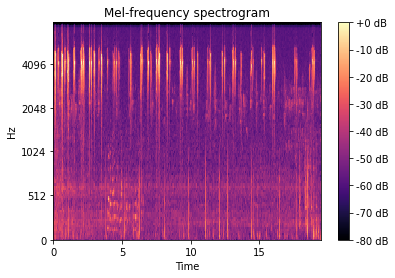

In [ ]:
spec, sr = librosa.load(df_500['relative_path'].iloc[0])
S = librosa.feature.melspectrogram(y=spec, n_mels = 128, sr=sr, n_fft = 3200, win_length = 3200, hop_length = 800)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
S_dB

array([[-20.73242 , -23.748913, -37.88363 , ..., -48.83502 , -37.745182,
        -29.44099 ],
       [-32.10997 , -33.200096, -40.237873, ..., -44.020718, -38.263397,
        -30.447378],
       [-35.39473 , -36.196426, -40.24769 , ..., -43.37515 , -37.017773,
        -30.033792],
       ...,
       [-69.97461 , -67.39561 , -65.74449 , ..., -65.514114, -65.835266,
        -64.72488 ],
       [-72.80531 , -75.19338 , -75.562935, ..., -76.456825, -73.83531 ,
        -69.29177 ],
       [-73.659546, -79.59181 , -80.      , ..., -80.      , -79.00021 ,
        -70.289345]], dtype=float32)